In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from model import UNet

from utils import showExamples, showImages, showImage

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

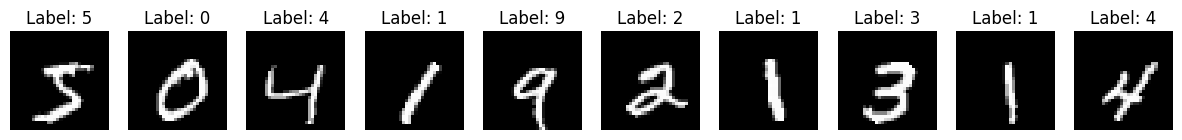

Max value: tensor(2.8215, device='cuda:0')
Min value: tensor(-0.4242, device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

# Used to pad the images from 28x28 to 32x32
# So the UNet can work with it.
# 32x32 is divisible by 2 multiple times, whereas 28x28 is not.
class PadTransform(object):
    def __call__(self, tensor):
        return F.pad(tensor, (2,2,2,2), mode='constant', value=0)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_set = PreloadedDataset.from_dataset(dataset, train_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [21]:
IMG_SIZE = 32
BATCH_SIZE = 32
timesteps = 16
time_bar = 1 - torch.linspace(0, 1.0, timesteps+1)

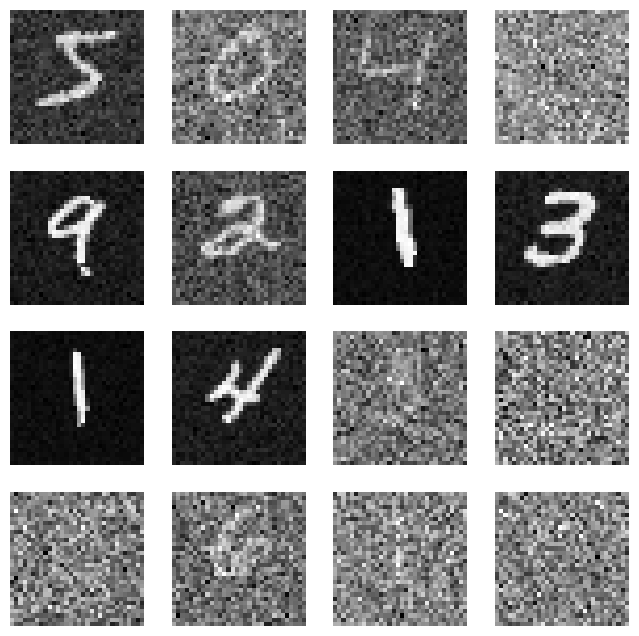

In [22]:
def forward_noise(x, t):
    a = time_bar[t].unsqueeze(2).unsqueeze(3).to(device).expand_as(x)
    b = time_bar[t+1].unsqueeze(2).unsqueeze(3).to(device).expand_as(x)

    noise = torch.randn_like(x).to(device)
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b

    return img_a, img_b

def generate_ts(num):
    return torch.randint(0, timesteps, (num,1))

num = 16
# Generate random time steps
t = generate_ts(num)
a, b = forward_noise(train_set[0:num][0], t)
# Shows different images with differents amounts of noise. (different timesteps)
showExamples(a)

In [28]:
def train(
        model,
        train_set,
        optimiser,
        criterion,
        losses = [],
        num_epochs=10,
):
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    for epoch in range(num_epochs):
        train_set.apply_transform()

        epoch_loss = 0.0
        loop = tqdm(train_loader, total=len(train_loader), leave=False)

        for data, _ in loop:

            ts = generate_ts(data.shape[0]).to(device)
            x_a, x_b = forward_noise(data, ts.to('cpu'))
            y_p = model(x_a, ts)

            loss = criterion(y_p, x_b)

            epoch_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            if epoch > 0:
                loop.set_postfix(loss=losses[-1])

        losses.append(epoch_loss / len(train_loader))
    return losses

In [31]:
model = UNet().to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.00034)
# L1 loss is the mean absolute error
criterion = torch.nn.L1Loss()
losses = []

In [32]:
losses = train(model, train_set, optimiser, criterion, losses, num_epochs=100)

Text(0.5, 1.0, 'L1 Loss (log scale)')

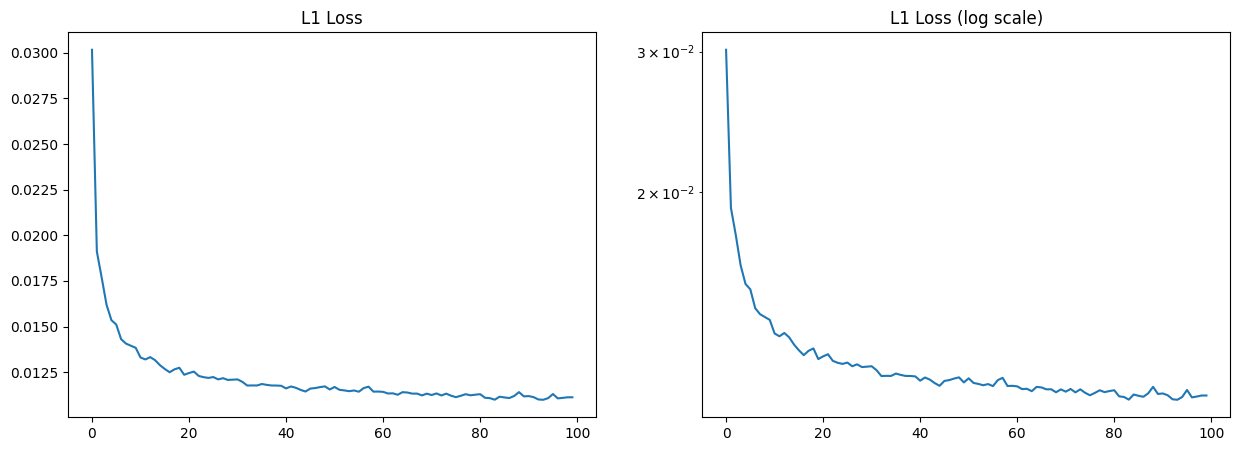

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(losses)
plt.title('L1 Loss')
plt.subplot(122)
plt.plot(losses)
plt.yscale('log')
plt.title('L1 Loss (log scale)')

100%|██████████| 16/16 [00:00<00:00, 373.60it/s]


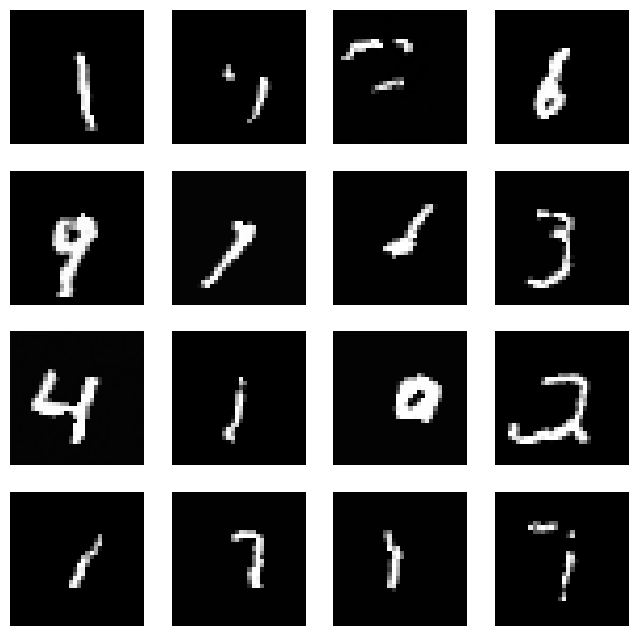

In [43]:
model.sample()

100%|██████████| 16/16 [00:00<00:00, 435.93it/s]


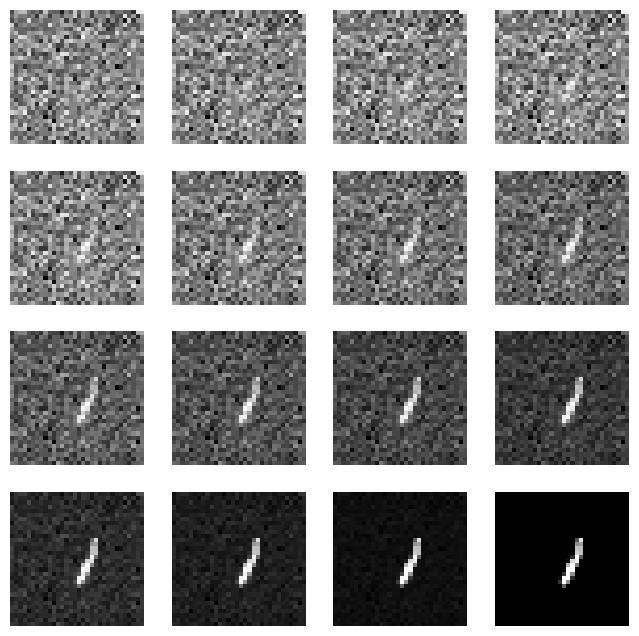

In [35]:
def sample_steps(model, timesteps=16):
    xs = []
    x = torch.randn((1, 1, 32, 32)).to(device)

    with torch.no_grad():
        for t in trange(timesteps):
            x = model.forward(x, torch.full([1, 1], t, dtype=torch.float32, device=device))
            xs.append(x)
    
    showExamples(xs)

sample_steps(model, timesteps=16)